<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/Drone_Red_Team_Scan_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
"""
Drone Cybersecurity Wargaming Simulation Framework
For authorized security testing and training scenarios only
"""

import socket
import threading
import time
import random
import json
import struct
import hashlib
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional, Tuple
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class DroneStatus:
    """Represents the current status of a simulated drone"""
    drone_id: str
    position: Tuple[float, float, float]  # lat, lon, alt
    battery: float
    armed: bool
    mode: str
    velocity: Tuple[float, float, float]  # x, y, z
    timestamp: float
    # New defense-related attributes
    countermeasures_active: bool = False
    system_hardened: bool = True # Assume defense drones are hardened by default
    flight_profile: str = "STANDARD" # STANDARD, EVASIVE, LOITER


class MAVLinkMessage:
    """Simplified MAVLink message structure for simulation"""

    def __init__(self, msg_id: int, payload: bytes):
        self.magic = 0xFE  # MAVLink v1 magic number
        self.length = len(payload)
        self.sequence = random.randint(0, 255)
        self.system_id = 1
        self.component_id = 1
        self.msg_id = msg_id
        self.payload = payload
        self.checksum = self._calculate_checksum()

    def _calculate_checksum(self) -> int:
        """Calculate MAVLink 1.0 checksum (CRC-16/MCRF4XX placeholder)"""
        # This is a simplified checksum for simulation purposes, not a true CRC-16
        # A simple XOR sum or sum could be used, ensuring it fits in 16 bits.
        # Let's use a simple sum modulo 65536 (2^16) to fit in a 2-byte field.
        data = struct.pack('<BBBBBB', self.length, self.sequence,
                          self.system_id, self.component_id, self.msg_id, self.magic) + self.payload
        checksum = 0
        for byte in data:
            checksum = (checksum + byte) & 0xFFFF # Sum and keep within 16 bits
        return checksum

    def to_bytes(self) -> bytes:
        """Convert message to bytes"""
        # MAVLink 1.0 message format:
        # <  : little-endian
        # B  : uint8_t (message start byte)
        # B  : uint8_t (payload length)
        # B  : uint8_t (packet sequence)
        # B  : uint8_t (system id)
        # B  : uint8_t (component id)
        # B  : uint8_t (message id)
        # ...: payload data
        # H  : uint16_t (checksum)

        header = struct.pack('<BBBBBB', self.magic, self.length, self.sequence,
                             self.system_id, self.component_id, self.msg_id)
        # Calculate checksum on header + payload
        checksum_data = header + self.payload
        checksum = 0
        for byte in checksum_data:
             checksum = (checksum + byte) & 0xFFFF

        return header + self.payload + struct.pack('<H', checksum)


class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) # Allow reusing the address
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")


    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

# Wargaming Scenario Controller
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = 14550 + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND")

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2]) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware")


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def run_war_scenario(self, num_friendly_drones: int = 3, num_enemy_drones: int = 2):
        """Setup and run a simulated war scenario with advanced attacks"""
        logger.info(f"Setting up war scenario with {num_friendly_drones} friendly and {num_enemy_drones} enemy drones")

        # Setup friendly drones
        friendly_drone_ids = []
        for i in range(num_friendly_drones):
            drone_id = f"FRIENDLY_DRONE_{i+1}"
            port = 14600 + i # Use a different port range for war scenario
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone
            friendly_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        # Setup enemy drones (potentially with different vulnerabilities/hardening)
        enemy_drone_ids = []
        for i in range(num_enemy_drones):
            drone_id = f"ENEMY_DRONE_{i+1}"
            port = 14700 + i # Another port range
            # Simulate enemy drones being less hardened
            enemy_drone = DroneSimulator(drone_id, port)
            enemy_drone.status.system_hardened = False
            enemy_drone.vulnerabilities = {
                 'weak_auth': True,
                 'unencrypted_comms': True,
                 'outdated_firmware': True,
                 'open_ports': [22, 23, 80, 14550, 14700]
            }
            self.drones[drone_id] = enemy_drone
            enemy_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=enemy_drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        time.sleep(3) # Allow drones to initialize
        logger.info("War scenario setup complete")

        # Execute a sequence of advanced red team attacks
        logger.info("Executing red team attacks in war scenario")

        # Target friendly drones with supply chain attack (simulating pre-compromise)
        for drone_id in friendly_drone_ids:
             self.red_team.supply_chain_attack(drone_id, "Malicious Hardware Implant")
             time.sleep(0.5)


        # Target enemy drones with swarm attack
        if len(enemy_drone_ids) > 0:
             self.red_team.swarm_attack(enemy_drone_ids)
             time.sleep(1)

        # Target friendly comms with electronic warfare attack
        if len(friendly_drone_ids) > 0:
             self.red_team.electronic_warfare_attack((2200.0, 2500.0), 15) # Jamming friendly comms
             time.sleep(1)

        # Attempt command injection on enemy drones
        for drone_id in enemy_drone_ids:
             self.red_team.command_injection_attack(drone_id, "RETURN_TO_BASE")
             time.sleep(0.5)

        # Simulate reconnaissance on enemy drones during the scenario
        self.red_team.network_scan("127.0.0.1") # Scan for enemy drone ports

        logger.info("Red team attacks in war scenario complete")

        # Generate report for war scenario
        report = self.red_team.generate_report()
        self._display_results(report)


    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup and run the war scenario
        scenario.run_war_scenario(num_friendly_drones=2, num_enemy_drones=2)


        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Thread-34 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
Exception in thread Thread-35 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
Exception in thread Thread-37 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-045798831944>", line 134, in _telemetry_loop
  File "<ipython-input-11-045798831944>", line 177, in _create_telemetry_message
  File "<ipython-input-11-045798831944>", line 50, in __init__
  File "<ipython-input-11-045798831944>", line 57, in _calculate_checksum
struct.error: ubyte format requires 0 <= 

Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-03T18:51:43.675995
Targets Discovered: 2
Attacks Attempted: 3
Success Rate: 33.3%

Critical Vulnerabilities Found: 1

Successful Attacks:
  - Electronic Warfare Attack: UNDETECTED
    Impact: Communication/Navigation systems potentially disrupted in range (2200.0, 2500.0)MHz
  - Command Injection: UNDETECTED
    Impact: Critical
  - Command Injection: UNDETECTED
    Impact: Critical

Recommendations:
  • Implement encrypted communication protocols
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing measures
  • Use frequency hopping for communication
  • Strengthen supply chain security protocols
  • Implement anti-jamming and anti-spoofing measures for EW
  • Develop countermeasures against coordinated swarm attacks

Press Ctrl+C to stop the simulation


I can add more scenarios to the simulation. What kind of scenarios would you like to simulate? For example, I can add scenarios that involve blue team actions or more advanced red team attacks.

# Task
Simulate advanced red teaming scenarios for defense drones in war scenarios, including sophisticated attack vectors like swarm attacks, electronic warfare, and supply chain attacks, and enhance the drone simulation and reporting to reflect these advanced scenarios.

## Define advanced attack vectors

### Subtask:
Introduce new `AttackVector` instances that represent more sophisticated attacks relevant to defense drones in a war scenario (e.g., swarm attacks, electronic warfare attacks, supply chain attacks).


**Reasoning**:
Add the new sophisticated attack vectors to the `attack_vectors` list in the `RedTeamFramework` class as requested in the instructions.



In [ ]:
class RedTeamFramework:
    """Red team framework for drone cybersecurity testing"""

    def __init__(self):
        self.attack_vectors = [
            AttackVector("GPS Spoofing", "HIGH", "Inject false GPS coordinates", 0.8, 0.3),
            AttackVector("Command Injection", "CRITICAL", "Inject malicious flight commands", 0.6, 0.5),
            AttackVector("Telemetry Sniffing", "MEDIUM", "Intercept telemetry data", 0.9, 0.1),
            AttackVector("Jamming Attack", "HIGH", "Disrupt communication channels", 0.7, 0.4),
            AttackVector("Firmware Exploit", "CRITICAL", "Exploit firmware vulnerabilities", 0.4, 0.7),
            AttackVector("Brute Force Auth", "MEDIUM", "Attempt to crack authentication", 0.5, 0.6),
            # Add new sophisticated attack vectors
            AttackVector("Swarm Attack", "CRITICAL", "Coordinate multiple drones for a synchronized attack", 0.5, 0.6),
            AttackVector("Electronic Warfare Attack", "HIGH", "Utilize electronic means to disrupt or deceive", 0.6, 0.5),
            AttackVector("Supply Chain Attack", "CRITICAL", "Compromise drone hardware or software during manufacturing or distribution", 0.3, 0.8)
        ]
        self.discovered_targets = []
        self.successful_attacks = []

## Implement advanced attack methods

### Subtask:
Add methods to the `RedTeamFramework` class to simulate the execution of these new attack vectors. These methods should include logic for success/failure, detection, and potential impact on the simulated drones.


**Reasoning**:
Add methods to the RedTeamFramework class to simulate the new attack vectors: swarm attack, electronic warfare attack, and supply chain attack. These methods will include logic for success/failure, detection, and impact, as well as logging.



In [ ]:
class RedTeamFramework:
    """Red team framework for drone cybersecurity testing"""

    def __init__(self):
        self.attack_vectors = [
            AttackVector("GPS Spoofing", "HIGH", "Inject false GPS coordinates", 0.8, 0.3),
            AttackVector("Command Injection", "CRITICAL", "Inject malicious flight commands", 0.6, 0.5),
            AttackVector("Telemetry Sniffing", "MEDIUM", "Intercept telemetry data", 0.9, 0.1),
            AttackVector("Jamming Attack", "HIGH", "Disrupt communication channels", 0.7, 0.4),
            AttackVector("Firmware Exploit", "CRITICAL", "Exploit firmware vulnerabilities", 0.4, 0.7),
            AttackVector("Brute Force Auth", "MEDIUM", "Attempt to crack authentication", 0.5, 0.6),
            # Add new sophisticated attack vectors
            AttackVector("Swarm Attack", "CRITICAL", "Coordinate multiple drones for a synchronized attack", 0.5, 0.6),
            AttackVector("Electronic Warfare Attack", "HIGH", "Utilize electronic means to disrupt or deceive", 0.6, 0.5),
            AttackVector("Supply Chain Attack", "CRITICAL", "Compromise drone hardware or software during manufacturing or distribution", 0.3, 0.8)
        ]
        self.discovered_targets = []
        self.successful_attacks = []

    def network_scan(self, target_range: str = "127.0.0.1") -> List[Dict]:
        """Simulate network scanning for drone targets"""
        logger.info(f"Scanning network range: {target_range}")

        # Simulate discovered services
        discovered = []
        for port in [22, 23, 80, 14550, 14551]:
            if random.random() > 0.3:  # 70% chance to find service
                service = {
                    'ip': target_range,
                    'port': port,
                    'service': self._identify_service(port),
                    'version': f"v{random.randint(1,5)}.{random.randint(0,9)}",
                    'vulnerabilities': self._check_vulnerabilities(port)
                }
                discovered.append(service)

        self.discovered_targets = discovered
        logger.info(f"Discovered {len(discovered)} services")
        return discovered

    def _identify_service(self, port: int) -> str:
        """Identify service running on port"""
        services = {
            22: "SSH",
            23: "Telnet",
            80: "HTTP",
            14550: "MAVLink",
            14551: "MAVLink-GCS"
        }
        return services.get(port, "Unknown")

    def _check_vulnerabilities(self, port: int) -> List[str]:
        """Check for common vulnerabilities"""
        vuln_map = {
            22: ["weak-passwords", "outdated-version"],
            23: ["unencrypted-auth", "default-credentials"],
            80: ["directory-traversal", "xss"],
            14550: ["unencrypted-comms", "no-auth"],
            14551: ["replay-attacks", "packet-injection"]
        }

        vulns = vuln_map.get(port, [])
        return [v for v in vulns if random.random() > 0.4]

    def packet_sniffer(self, interface: str = "lo", duration: int = 10) -> List[Dict]:
        """Simulate packet sniffing"""
        logger.info(f"Starting packet sniffing on {interface} for {duration}s")

        captured_packets = []
        start_time = time.time()

        while time.time() - start_time < duration:
            # Simulate captured packet
            packet = {
                'timestamp': time.time(),
                'src_ip': f"192.168.1.{random.randint(1, 254)}",
                'dst_ip': f"192.168.1.{random.randint(1, 254)}",
                'protocol': random.choice(['UDP', 'TCP', 'ICMP']),
                'size': random.randint(64, 1500),
                'payload_type': random.choice(['telemetry', 'command', 'heartbeat', 'data'])
            }
            captured_packets.append(packet)
            time.sleep(0.1)

        logger.info(f"Captured {len(captured_packets)} packets")
        return captured_packets

    def gps_spoofing_attack(self, target_drone: str, fake_coords: Tuple[float, float, float]) -> Dict:
        """Simulate GPS spoofing attack"""
        logger.info(f"Attempting GPS spoofing on {target_drone}")

        attack = next((a for a in self.attack_vectors if a.name == "GPS Spoofing"), None)
        if not attack:
            logger.error("GPS Spoofing attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'GPS Spoofing',
            'target': target_drone,
            'fake_coordinates': fake_coords,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': 'High' if success and not detected else 'Medium' if success else 'None'
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"GPS spoofing {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("GPS spoofing failed")

        return result

    def command_injection_attack(self, target_drone: str, malicious_command: str) -> Dict:
        """Simulate command injection attack"""
        logger.info(f"Attempting command injection on {target_drone}")

        attack = next((a for a in self.attack_vectors if a.name == "Command Injection"), None)
        if not attack:
            logger.error("Command Injection attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'Command Injection',
            'target': target_drone,
            'command': malicious_command,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': 'Critical' if success and not detected else 'High' if success else 'None'
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Command injection {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("Command injection failed")

        return result

    def jamming_attack(self, frequency: float, duration: int) -> Dict:
        """Simulate jamming attack"""
        logger.info(f"Simulating jamming attack on {frequency}MHz for {duration}s")

        attack = next((a for a in self.attack_vectors if a.name == "Jamming Attack"), None)
        if not attack:
            logger.error("Jamming Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'Jamming Attack',
            'frequency': frequency,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'affected_drones': random.randint(1, 5) if success else 0
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Jamming attack {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("Jamming attack failed")

        return result

    def swarm_attack(self, target_drones: List[str]) -> Dict:
        """Simulate a swarm attack on a list of target drones"""
        logger.info(f"Attempting swarm attack on targets: {target_drones}")

        attack = next((a for a in self.attack_vectors if a.name == "Swarm Attack"), None)
        if not attack:
            logger.error("Swarm Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., change mode or disable a percentage of drones
            affected_count = int(len(target_drones) * random.uniform(0.3, 0.8)) # Impact 30-80% of targets
            impact_description = f"Affected {affected_count}/{len(target_drones)} drones (e.g., mode change, temporary disable)"
            logger.warning(f"Swarm attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Swarm attack failed.")


        result = {
            'attack_type': 'Swarm Attack',
            'targets': target_drones,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result

    def electronic_warfare_attack(self, frequency_range: Tuple[float, float], duration: int) -> Dict:
        """Simulate an electronic warfare attack"""
        logger.info(f"Attempting electronic warfare attack on frequency range {frequency_range}MHz for {duration}s")

        attack = next((a for a in self.attack_vectors if a.name == "Electronic Warfare Attack"), None)
        if not attack:
            logger.error("Electronic Warfare Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., communication disruption, navigation interference
            impact_description = f"Communication/Navigation systems potentially disrupted in range {frequency_range}MHz"
            logger.warning(f"Electronic Warfare attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Electronic Warfare attack failed.")

        result = {
            'attack_type': 'Electronic Warfare Attack',
            'frequency_range': frequency_range,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result

    def supply_chain_attack(self, target_drone: str, compromise_type: str) -> Dict:
        """Simulate the discovery or exploitation of a supply chain compromise"""
        logger.info(f"Simulating supply chain attack discovery/exploitation on {target_drone} with type: {compromise_type}")

        attack = next((a for a in self.attack_vectors if a.name == "Supply Chain Attack"), None)
        if not attack:
            logger.error("Supply Chain Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate # Simulate success of exploitation/discovery
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., persistent backdoor, compromised data, hardware malfunction
            impact_description = f"Significant compromise detected/exploited: {compromise_type} on {target_drone}"
            logger.warning(f"Supply chain attack simulation {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Supply chain attack simulation failed.")

        result = {
            'attack_type': 'Supply Chain Attack',
            'target': target_drone,
            'compromise_type': compromise_type,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result


    def generate_report(self) -> Dict:
        """Generate comprehensive assessment report"""
        report = {
            'assessment_date': datetime.now().isoformat(),
            'targets_discovered': len(self.discovered_targets),
            'attacks_attempted': len(self.successful_attacks),
            'success_rate': len(self.successful_attacks) / max(1, len(self.attack_vectors)) * 100,
            'critical_vulnerabilities': [
                t for t in self.discovered_targets
                if any('unencrypted' in v or 'no-auth' in v for v in t.get('vulnerabilities', []))
            ],
            'successful_attacks': self.successful_attacks,
            'recommendations': [
                "Implement encrypted communication protocols",
                "Enable strong authentication mechanisms",
                "Deploy intrusion detection systems",
                "Regular firmware updates and security patches",
                "Implement GPS anti-spoofing measures",
                "Use frequency hopping for communication",
                "Strengthen supply chain security protocols",
                "Implement anti-jamming and anti-spoofing measures for EW",
                "Develop countermeasures against coordinated swarm attacks"
            ]
        }

        return report

## Enhance drone simulation

### Subtask:
Modify the `DroneSimulator` class to include vulnerabilities and behaviors that are relevant to defense drones and susceptible to the new attack vectors (e.g., countermeasures, hardened systems, different flight profiles).


**Reasoning**:
Modify the `DroneStatus` dataclass and the `DroneSimulator` class to include defense-related attributes, update the `_update_status` and `_process_command` methods, and add logic to simulate interactions with advanced attacks.



In [ ]:
@dataclass
class DroneStatus:
    """Represents the current status of a simulated drone"""
    drone_id: str
    position: Tuple[float, float, float]  # lat, lon, alt
    battery: float
    armed: bool
    mode: str
    velocity: Tuple[float, float, float]  # x, y, z
    timestamp: float
    # New defense-related attributes
    countermeasures_active: bool = False
    system_hardened: bool = True # Assume defense drones are hardened by default
    flight_profile: str = "STANDARD" # STANDARD, EVASIVE, LOITER

class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")


    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

# Wargaming Scenario Controller
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = 14550 + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND")

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2]) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware")


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup scenario
        scenario.setup_scenario(num_drones=2)

        # Run red team exercise
        scenario.run_red_team_exercise()

        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Exception in thread Thread-14 (start):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
Thread-13 (start):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-afbee59d0837>", line 46, in start
OSError: [Errno 98] Address already in use
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-afbee59d0837>", line 46, in start
OSError: [Errno 98] Address already in use


Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-03T15:01:05.546381
Targets Discovered: 3
Attacks Attempted: 6
Success Rate: 66.7%

Critical Vulnerabilities Found: 1

Successful Attacks:
  - GPS Spoofing: UNDETECTED
    Impact: High
  - Command Injection: UNDETECTED
    Impact: Critical
  - GPS Spoofing: UNDETECTED
    Impact: High
  - Command Injection: DETECTED
    Impact: High
  - Jamming Attack: DETECTED
  - Electronic Warfare Attack: DETECTED
    Impact: Communication/Navigation systems potentially disrupted in range (2000.0, 3000.0)MHz

Recommendations:
  • Implement encrypted communication protocols
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing measures
  • Use frequency hopping for communication
  • Strengthen supply chain security protocols
  • Implement anti-jamming and anti-spoofing measures for EW
  • Develop countermeasures against coordinat

**Reasoning**:
The previous execution failed because the ports were already in use. This is likely due to the notebook environment not properly cleaning up resources between executions. I will modify the code to use a higher starting port number to reduce the chance of collision.



In [ ]:
@dataclass
class DroneStatus:
    """Represents the current status of a simulated drone"""
    drone_id: str
    position: Tuple[float, float, float]  # lat, lon, alt
    battery: float
    armed: bool
    mode: str
    velocity: Tuple[float, float, float]  # x, y, z
    timestamp: float
    # New defense-related attributes
    countermeasures_active: bool = False
    system_hardened: bool = True # Assume defense drones are hardened by default
    flight_profile: str = "STANDARD" # STANDARD, EVASIVE, LOITER

class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        # Use SO_REUSEADDR to allow reusing the address quickly
        self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")


    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

# Wargaming Scenario Controller
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        # Use a higher starting port to avoid conflicts
        starting_port = 14600

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = starting_port + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND")

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2]) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware")


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup scenario
        scenario.setup_scenario(num_drones=2)

        # Run red team exercise
        scenario.run_red_team_exercise()

        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Thread-16 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
Exception in thread Thread-18 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-98cef8bc8466>", line 63, in _telemetry_loop
  File "<ipython-input-5-98cef8bc8466>", line 106, in _create_telemetry_message
  File "<ipython-input-1-3d0bca412de5>", line 54, in __init__
  File "<ipython-input-1-3d0bca412de5>", line 58, in _calculate_checksum
struct.error: ubyte format requires 0 <= number <= 255
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-98cef8bc8466>", line 63, in _telemetry_loop
  File "<ipython-input-5-98cef8bc8

Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-03T15:06:25.317668
Targets Discovered: 5
Attacks Attempted: 5
Success Rate: 55.6%

Critical Vulnerabilities Found: 2

Successful Attacks:
  - GPS Spoofing: UNDETECTED
    Impact: High
  - GPS Spoofing: UNDETECTED
    Impact: High
  - Command Injection: DETECTED
    Impact: High
  - Swarm Attack: DETECTED
    Impact: Affected 0/2 drones (e.g., mode change, temporary disable)
  - Electronic Warfare Attack: UNDETECTED
    Impact: Communication/Navigation systems potentially disrupted in range (2000.0, 3000.0)MHz

Recommendations:
  • Implement encrypted communication protocols
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing measures
  • Use frequency hopping for communication
  • Strengthen supply chain security protocols
  • Implement anti-jamming and anti-spoofing measures for EW
  • Develop countermeasures a

## Define advanced attack vectors

### Subtask:
Introduce new `AttackVector` instances that represent more sophisticated attacks relevant to defense drones in a war scenario (e.g., swarm attacks, electronic warfare attacks, supply chain attacks).

**Reasoning**:
Add the new sophisticated attack vectors to the `attack_vectors` list in the `RedTeamFramework` class as requested in the instructions.

In [ ]:
class RedTeamFramework:
    """Red team framework for drone cybersecurity testing"""

    def __init__(self):
        self.attack_vectors = [
            AttackVector("GPS Spoofing", "HIGH", "Inject false GPS coordinates", 0.8, 0.3),
            AttackVector("Command Injection", "CRITICAL", "Inject malicious flight commands", 0.6, 0.5),
            AttackVector("Telemetry Sniffing", "MEDIUM", "Intercept telemetry data", 0.9, 0.1),
            AttackVector("Jamming Attack", "HIGH", "Disrupt communication channels", 0.7, 0.4),
            AttackVector("Firmware Exploit", "CRITICAL", "Exploit firmware vulnerabilities", 0.4, 0.7),
            AttackVector("Brute Force Auth", "MEDIUM", "Attempt to crack authentication", 0.5, 0.6),
            # Add new sophisticated attack vectors
            AttackVector("Swarm Attack", "CRITICAL", "Coordinate multiple drones for a synchronized attack", 0.5, 0.6),
            AttackVector("Electronic Warfare Attack", "HIGH", "Utilize electronic means to disrupt or deceive", 0.6, 0.5),
            AttackVector("Supply Chain Attack", "CRITICAL", "Compromise drone hardware or software during manufacturing or distribution", 0.3, 0.8)
        ]
        self.discovered_targets = []
        self.successful_attacks = []

## Implement advanced attack methods

### Subtask:
Add methods to the `RedTeamFramework` class to simulate the execution of these new attack vectors. These methods should include logic for success/failure, detection, and potential impact on the simulated drones.

**Reasoning**:
Add methods to the RedTeamFramework class to simulate the new attack vectors: swarm attack, electronic warfare attack, and supply chain attack. These methods will include logic for success/failure, detection, and impact, as well as logging.

In [ ]:
class RedTeamFramework:
    """Red team framework for drone cybersecurity testing"""

    def __init__(self):
        self.attack_vectors = [
            AttackVector("GPS Spoofing", "HIGH", "Inject false GPS coordinates", 0.8, 0.3),
            AttackVector("Command Injection", "CRITICAL", "Inject malicious flight commands", 0.6, 0.5),
            AttackVector("Telemetry Sniffing", "MEDIUM", "Intercept telemetry data", 0.9, 0.1),
            AttackVector("Jamming Attack", "HIGH", "Disrupt communication channels", 0.7, 0.4),
            AttackVector("Firmware Exploit", "CRITICAL", "Exploit firmware vulnerabilities", 0.4, 0.7),
            AttackVector("Brute Force Auth", "MEDIUM", "Attempt to crack authentication", 0.5, 0.6),
            # Add new sophisticated attack vectors
            AttackVector("Swarm Attack", "CRITICAL", "Coordinate multiple drones for a synchronized attack", 0.5, 0.6),
            AttackVector("Electronic Warfare Attack", "HIGH", "Utilize electronic means to disrupt or deceive", 0.6, 0.5),
            AttackVector("Supply Chain Attack", "CRITICAL", "Compromise drone hardware or software during manufacturing or distribution", 0.3, 0.8)
        ]
        self.discovered_targets = []
        self.successful_attacks = []

    def network_scan(self, target_range: str = "127.0.0.1") -> List[Dict]:
        """Simulate network scanning for drone targets"""
        logger.info(f"Scanning network range: {target_range}")

        # Simulate discovered services
        discovered = []
        for port in [22, 23, 80, 14550, 14551, 14600, 14700]: # Include new war scenario ports
            if random.random() > 0.3:  # 70% chance to find service
                service = {
                    'ip': target_range,
                    'port': port,
                    'service': self._identify_service(port),
                    'version': f"v{random.randint(1,5)}.{random.randint(0,9)}",
                    'vulnerabilities': self._check_vulnerabilities(port)
                }
                discovered.append(service)

        self.discovered_targets = discovered
        logger.info(f"Discovered {len(discovered)} services")
        return discovered

    def _identify_service(self, port: int) -> str:
        """Identify service running on port"""
        services = {
            22: "SSH",
            23: "Telnet",
            80: "HTTP",
            14550: "MAVLink",
            14551: "MAVLink-GCS",
            14600: "MAVLink-Friendly", # New service types for war scenario
            14700: "MAVLink-Enemy"
        }
        return services.get(port, "Unknown")

    def _check_vulnerabilities(self, port: int) -> List[str]:
        """Check for common vulnerabilities"""
        vuln_map = {
            22: ["weak-passwords", "outdated-version"],
            23: ["unencrypted-auth", "default-credentials"],
            80: ["directory-traversal", "xss"],
            14550: ["unencrypted-comms", "no-auth"],
            14551: ["replay-attacks", "packet-injection"],
            14600: ["encrypted-comms-weak-keys"], # Example vulnerabilities for friendly drones
            14700: ["unencrypted-comms", "default-credentials", "outdated-firmware"] # Example vulnerabilities for enemy drones
        }

        vulns = vuln_map.get(port, [])
        return [v for v in vulns if random.random() > 0.4]

    def packet_sniffer(self, interface: str = "lo", duration: int = 10) -> List[Dict]:
        """Simulate packet sniffing"""
        logger.info(f"Starting packet sniffing on {interface} for {duration}s")

        captured_packets = []
        start_time = time.time()

        while time.time() - start_time < duration:
            # Simulate captured packet
            packet = {
                'timestamp': time.time(),
                'src_ip': f"192.168.1.{random.randint(1, 254)}",
                'dst_ip': f"192.168.1.{random.randint(1, 254)}",
                'protocol': random.choice(['UDP', 'TCP', 'ICMP']),
                'size': random.randint(64, 1500),
                'payload_type': random.choice(['telemetry', 'command', 'heartbeat', 'data'])
            }
            captured_packets.append(packet)
            time.sleep(0.1)

        logger.info(f"Captured {len(captured_packets)} packets")
        return captured_packets

    def gps_spoofing_attack(self, target_drone: str, fake_coords: Tuple[float, float, float]) -> Dict:
        """Simulate GPS spoofing attack"""
        logger.info(f"Attempting GPS spoofing on {target_drone}")

        attack = next((a for a in self.attack_vectors if a.name == "GPS Spoofing"), None)
        if not attack:
            logger.error("GPS Spoofing attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'GPS Spoofing',
            'target': target_drone,
            'fake_coordinates': fake_coords,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': 'High' if success and not detected else 'Medium' if success else 'None'
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"GPS spoofing {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("GPS spoofing failed")

        return result

    def command_injection_attack(self, target_drone: str, malicious_command: str) -> Dict:
        """Simulate command injection attack"""
        logger.info(f"Attempting command injection on {target_drone}")

        attack = next((a for a in self.attack_vectors if a.name == "Command Injection"), None)
        if not attack:
            logger.error("Command Injection attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'Command Injection',
            'target': target_drone,
            'command': malicious_command,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': 'Critical' if success and not detected else 'High' if success else 'None'
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Command injection {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("Command injection failed")

        return result

    def jamming_attack(self, frequency: float, duration: int) -> Dict:
        """Simulate jamming attack"""
        logger.info(f"Simulating jamming attack on {frequency}MHz for {duration}s")

        attack = next((a for a in self.attack_vectors if a.name == "Jamming Attack"), None)
        if not attack:
            logger.error("Jamming Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        result = {
            'attack_type': 'Jamming Attack',
            'frequency': frequency,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'affected_drones': random.randint(1, 5) if success else 0
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Jamming attack {'DETECTED' if detected else 'SUCCESSFUL'}")
        else:
            logger.info("Jamming attack failed")

        return result

    def swarm_attack(self, target_drones: List[str]) -> Dict:
        """Simulate a swarm attack on a list of target drones"""
        logger.info(f"Attempting swarm attack on targets: {target_drones}")

        attack = next((a for a in self.attack_vectors if a.name == "Swarm Attack"), None)
        if not attack:
            logger.error("Swarm Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., change mode or disable a percentage of drones
            affected_count = int(len(target_drones) * random.uniform(0.3, 0.8)) # Impact 30-80% of targets
            impact_description = f"Affected {affected_count}/{len(target_drones)} drones (e.g., mode change, temporary disable)"
            logger.warning(f"Swarm attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Swarm attack failed.")


        result = {
            'attack_type': 'Swarm Attack',
            'targets': target_drones,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result

    def electronic_warfare_attack(self, frequency_range: Tuple[float, float], duration: int) -> Dict:
        """Simulate an electronic warfare attack"""
        logger.info(f"Attempting electronic warfare attack on frequency range {frequency_range}MHz for {duration}s")

        attack = next((a for a in self.attack_vectors if a.name == "Electronic Warfare Attack"), None)
        if not attack:
            logger.error("Electronic Warfare Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., communication disruption, navigation interference
            impact_description = f"Communication/Navigation systems potentially disrupted in range {frequency_range}MHz"
            logger.warning(f"Electronic Warfare attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Electronic Warfare attack failed.")

        result = {
            'attack_type': 'Electronic Warfare Attack',
            'frequency_range': frequency_range,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result

    def supply_chain_attack(self, target_drone: str, compromise_type: str) -> Dict:
        """Simulate the discovery or exploitation of a supply chain compromise"""
        logger.info(f"Simulating supply chain attack discovery/exploitation on {target_drone} with type: {compromise_type}")

        attack = next((a for a in self.attack_vectors if a.name == "Supply Chain Attack"), None)
        if not attack:
            logger.error("Supply Chain Attack attack vector not found.")
            return {}

        success = random.random() < attack.success_rate # Simulate success of exploitation/discovery
        detected = random.random() < attack.detection_rate if success else False

        impact_description = "None"
        if success:
            # Simulate impact: e.g., persistent backdoor, compromised data, hardware malfunction
            impact_description = f"Significant compromise detected/exploited: {compromise_type} on {target_drone}"
            logger.warning(f"Supply chain attack simulation {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
            logger.info("Supply chain attack simulation failed.")

        result = {
            'attack_type': 'Supply Chain Attack',
            'target': target_drone,
            'compromise_type': compromise_type,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)

        return result


    def generate_report(self) -> Dict:
        """Generate comprehensive assessment report"""
        report = {
            'assessment_date': datetime.now().isoformat(),
            'targets_discovered': len(self.discovered_targets),
            'attacks_attempted': len(self.successful_attacks),
            'success_rate': len(self.successful_attacks) / max(1, len(self.attack_vectors)) * 100,
            'critical_vulnerabilities': [
                t for t in self.discovered_targets
                if any('unencrypted' in v or 'no-auth' in v or 'weak-keys' in v for v in t.get('vulnerabilities', [])) # Include weak-keys
            ],
            'successful_attacks': self.successful_attacks,
            'recommendations': [
                "Implement encrypted communication protocols with strong key management", # Refine recommendation
                "Enable strong authentication mechanisms",
                "Deploy intrusion detection systems and monitoring for anomalies", # Refine recommendation
                "Regular firmware updates and security patches",
                "Implement GPS anti-spoofing and validation measures", # Refine recommendation
                "Use frequency hopping and spread spectrum techniques for communication", # Refine recommendation
                "Strengthen supply chain security protocols and hardware integrity checks", # Refine recommendation
                "Implement advanced anti-jamming and cognitive electronic warfare defenses", # Refine recommendation
                "Develop countermeasures against coordinated swarm attacks and autonomous response" # Refine recommendation
            ]
        }

        # Add war scenario specific metrics
        friendly_drones_attacked = sum(1 for a in self.successful_attacks if 'FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', [])))
        enemy_drones_attacked = sum(1 for a in self.successful_attacks if 'ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', [])))

        report['war_scenario_metrics'] = {
            'friendly_drones_attacked': friendly_drones_attacked,
            'enemy_drones_attacked': enemy_drones_attacked,
            'successful_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False)),
            'successful_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False)),
            'detected_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('detected', False)),
            'detected_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('detected', False)),
            'impactful_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False) and a.get('impact', 'None') != 'None'),
            'impactful_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False) and a.get('impact', 'None') != 'None'),

        }


        return report

## Enhance drone simulation

### Subtask:
Modify the `DroneSimulator` class to include vulnerabilities and behaviors that are relevant to defense drones and susceptible to the new attack vectors (e.g., countermeasures, hardened systems, different flight profiles).

**Reasoning**:
Modify the `DroneStatus` dataclass and the `DroneSimulator` class to include defense-related attributes, update the `_update_status` and `_process_command` methods, and add logic to simulate interactions with advanced attacks.

In [ ]:
@dataclass
class DroneStatus:
    """Represents the current status of a simulated drone"""
    drone_id: str
    position: Tuple[float, float, float]  # lat, lon, alt
    battery: float
    armed: bool
    mode: str
    velocity: Tuple[float, float, float]  # x, y, z
    timestamp: float
    # New defense-related attributes
    countermeasures_active: bool = False
    system_hardened: bool = True # Assume defense drones are hardened by default
    flight_profile: str = "STANDARD" # STANDARD, EVASIVE, LOITER

class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")


    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

# Wargaming Scenario Controller
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = 14550 + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND")

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2]) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware")


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup scenario
        scenario.setup_scenario(num_drones=2)

        # Run red team exercise
        scenario.run_red_team_exercise()

        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Exception in thread Thread-19 (start):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
Thread-20 (start):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-afbee59d0837>", line 46, in start
OSError: [Errno 98] Address already in use
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-afbee59d0837>", line 46, in start
OSError: [Errno 98] Address already in use


Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-03T15:18:19.354546
Targets Discovered: 3
Attacks Attempted: 5
Success Rate: 55.6%

Critical Vulnerabilities Found: 0

Successful Attacks:
  - GPS Spoofing: DETECTED
    Impact: Medium
  - Command Injection: DETECTED
    Impact: High
  - Jamming Attack: DETECTED
  - Electronic Warfare Attack: UNDETECTED
    Impact: Communication/Navigation systems potentially disrupted in range (2000.0, 3000.0)MHz
  - Supply Chain Attack: DETECTED
    Impact: Significant compromise detected/exploited: Malicious Firmware on DRONE_1

Recommendations:
  • Implement encrypted communication protocols
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing measures
  • Use frequency hopping for communication
  • Strengthen supply chain security protocols
  • Implement anti-jamming and anti-spoofing measures for EW
  • Develop countermeasur

## Develop War Scenario Logic

### Subtask:
Create a new method in the `WargamingScenario` class to orchestrate a "war scenario." This method will involve setting up multiple drones, potentially including "friendly" and "enemy" drones, and executing a sequence of advanced red team attacks against them.

**Reasoning**:
Add a `run_war_scenario` method to the `WargamingScenario` class that sets up drones and executes a sequence of advanced red team attacks, including the newly added swarm, electronic warfare, and supply chain attacks.

In [ ]:
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        # Use a higher starting port to avoid conflicts
        starting_port = 15000

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = starting_port + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND")

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2]) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware")


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def run_war_scenario(self, num_friendly_drones: int = 3, num_enemy_drones: int = 2):
        """Setup and run a simulated war scenario with advanced attacks"""
        logger.info(f"Setting up war scenario with {num_friendly_drones} friendly and {num_enemy_drones} enemy drones")

        # Setup friendly drones
        friendly_drone_ids = []
        # Use a higher starting port for friendly drones in war scenario
        friendly_starting_port = 15100
        for i in range(num_friendly_drones):
            drone_id = f"FRIENDLY_DRONE_{i+1}"
            port = friendly_starting_port + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone
            friendly_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        # Setup enemy drones (potentially with different vulnerabilities/hardening)
        enemy_drone_ids = []
        # Use a higher starting port for enemy drones in war scenario
        enemy_starting_port = 15200
        for i in range(num_enemy_drones):
            drone_id = f"ENEMY_DRONE_{i+1}"
            port = enemy_starting_port + i
            enemy_drone = DroneSimulator(drone_id, port)
            # Simulate enemy drones being less hardened
            enemy_drone.status.system_hardened = False
            enemy_drone.vulnerabilities = {
                 'weak_auth': True,
                 'unencrypted_comms': True,
                 'outdated_firmware': True,
                 'open_ports': [22, 23, 80, 14550, enemy_starting_port + i] # Include the specific enemy drone port
            }
            self.drones[drone_id] = enemy_drone
            enemy_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=enemy_drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        time.sleep(3) # Allow drones to initialize
        logger.info("War scenario setup complete")

        # Execute a sequence of advanced red team attacks
        logger.info("Executing red team attacks in war scenario")

        # Target friendly drones with supply chain attack (simulating pre-compromise)
        for drone_id in friendly_drone_ids:
             self.red_team.supply_chain_attack(drone_id, "Malicious Hardware Implant")
             time.sleep(0.5)


        # Target enemy drones with swarm attack
        if len(enemy_drone_ids) > 0:
             self.red_team.swarm_attack(enemy_drone_ids)
             time.sleep(1)

        # Target friendly comms with electronic warfare attack
        if len(friendly_drone_ids) > 0:
             self.red_team.electronic_warfare_attack((2200.0, 2500.0), 15) # Jamming friendly comms
             time.sleep(1)

        # Attempt command injection on enemy drones
        for drone_id in enemy_drone_ids:
             self.red_team.command_injection_attack(drone_id, "RETURN_TO_BASE")
             time.sleep(0.5)

        # Simulate reconnaissance on enemy drones during the scenario
        self.red_team.network_scan("127.0.0.1") # Scan for enemy drone ports

        logger.info("Red team attacks in war scenario complete")

        # Generate report for war scenario
        report = self.red_team.generate_report()
        self._display_results(report)


    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup and run the war scenario
        scenario.run_war_scenario(num_friendly_drones=2, num_enemy_drones=2)


        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Thread-23 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-afbee59d0837>", line 61, in _telemetry_loop
  File "<ipython-input-8-afbee59d0837>", line 104, in _create_telemetry_message
  File "<ipython-input-1-3d0bca412de5>", line 54, in __init__
  File "<ipython-input-1-3d0bca412de5>", line 58, in _calculate_checksum
struct.error: ubyte format requires 0 <= number <= 255
Exception in thread Thread-25 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-afbee59d0837>", line 61, in _telemetry_loop
  File "<ipython-input-8-afbee59d0

Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-03T17:26:40.847255
Targets Discovered: 4
Attacks Attempted: 3
Success Rate: 33.3%

Critical Vulnerabilities Found: 0

Successful Attacks:
  - Swarm Attack: UNDETECTED
    Impact: Affected 0/2 drones (e.g., mode change, temporary disable)
  - Command Injection: UNDETECTED
    Impact: Critical
  - Command Injection: UNDETECTED
    Impact: Critical

Recommendations:
  • Implement encrypted communication protocols
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing measures
  • Use frequency hopping for communication
  • Strengthen supply chain security protocols
  • Implement anti-jamming and anti-spoofing measures for EW
  • Develop countermeasures against coordinated swarm attacks

Press Ctrl+C to stop the simulation

Shutting down simulation...
Simulation stopped.


# Task
Implement Blue Team actions in the drone wargaming simulation, including capabilities for defense, detection, and response to attacks, and integrate these actions into the simulation scenario and reporting.

## Define blue team capabilities

### Subtask:
Create a new class or modify existing ones to represent the Blue Team and define their potential actions (e.g., deploy firewall, activate IDS, patch firmware, activate countermeasures).


**Reasoning**:
Create the BlueTeamFramework class with an initialization method and define blue team actions within it.



In [ ]:
@dataclass
class BlueTeamAction:
    """Represents a potential action the Blue Team can take"""
    name: str
    description: str
    effectiveness: Dict[str, float] # Effectiveness against different attack types (e.g., {'GPS Spoofing': 0.7})
    detection_capability: Dict[str, float] # Capability to detect different attack types (e.g., {'Jamming Attack': 0.6})


class BlueTeamFramework:
    """Blue team framework for drone cybersecurity defense"""

    def __init__(self):
        self.actions = [
            BlueTeamAction(
                name="Deploy Firewall",
                description="Implement network filtering rules",
                effectiveness={'Network Scan': 0.5, 'Brute Force Auth': 0.6},
                detection_capability={'Network Scan': 0.7}
            ),
            BlueTeamAction(
                name="Activate IDS",
                description="Monitor network traffic for malicious patterns",
                effectiveness={}, # IDS primarily detects, not prevents in this simulation
                detection_capability={'GPS Spoofing': 0.4, 'Command Injection': 0.5, 'Telemetry Sniffing': 0.8, 'Swarm Attack': 0.6, 'Electronic Warfare Attack': 0.5}
            ),
            BlueTeamAction(
                name="Patch Firmware",
                description="Update drone firmware to address known vulnerabilities",
                effectiveness={'Firmware Exploit': 0.9, 'Supply Chain Attack': 0.7},
                detection_capability={}
            ),
            BlueTeamAction(
                name="Activate Countermeasures",
                description="Engage onboard defensive systems (e.g., anti-jamming, anti-spoofing)",
                effectiveness={'Jamming Attack': 0.8, 'GPS Spoofing': 0.7, 'Electronic Warfare Attack': 0.7},
                detection_capability={'Jamming Attack': 0.6, 'GPS Spoofing': 0.6, 'Electronic Warfare Attack': 0.6}
            ),
             BlueTeamAction(
                name="Implement Strong Authentication",
                description="Enforce strong password policies and multi-factor authentication",
                effectiveness={'Weak Auth': 0.9, 'Brute Force Auth': 0.8},
                detection_capability={'Brute Force Auth': 0.7}
            ),
            BlueTeamAction(
                name="Encrypt Communications",
                description="Secure communication channels with encryption",
                effectiveness={'Telemetry Sniffing': 0.9, 'Unencrypted Comms': 1.0},
                detection_capability={}
            ),
             BlueTeamAction(
                name="Supply Chain Monitoring",
                description="Monitor hardware and software supply chains for compromises",
                effectiveness={},
                detection_capability={'Supply Chain Attack': 0.9}
            )
        ]
        logger.info(f"Blue Team Framework initialized with {len(self.actions)} actions.")


## Implement Blue Team Logic

### Subtask:
Add methods to the `DroneSimulator` and/or a new Blue Team class to simulate the effects of Blue Team actions on drone vulnerabilities, attack detection probabilities, and response mechanisms.

**Reasoning**:

Modify the `DroneSimulator` to include methods for applying Blue Team actions and update the attack processing logic to consider the effects of active countermeasures and other defenses. Also, update the `RedTeamFramework` to consider the detection capabilities of the Blue Team during attacks.

In [ ]:
class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }
        self.active_defenses: Dict[str, bool] = {} # Track active blue team defenses

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) # Allow reusing the address
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

    def apply_defense(self, defense_name: str, active: bool):
        """Applies a blue team defense to the drone."""
        self.active_defenses[defense_name] = active
        logger.info(f"Drone {self.drone_id}: Defense '{defense_name}' set to {active}")

    def is_vulnerable(self, vulnerability_type: str) -> bool:
        """Checks if the drone is vulnerable to a specific type of attack."""
        # Consider base vulnerabilities and whether relevant defenses are active
        base_vulnerable = self.vulnerabilities.get(vulnerability_type, False)

        # Example: If 'Patch Firmware' is active, it mitigates 'outdated_firmware'
        if vulnerability_type == 'outdated_firmware' and self.active_defenses.get('Patch Firmware', False):
            return False
        # Example: If 'Implement Strong Authentication' is active, it mitigates 'weak_auth'
        if vulnerability_type == 'weak_auth' and self.active_defenses.get('Implement Strong Authentication', False):
            return False
        # Example: If 'Encrypt Communications' is active, it mitigates 'unencrypted_comms'
        if vulnerability_type == 'unencrypted_comms' and self.active_defenses.get('Encrypt Communications', False):
            return False

        return base_vulnerable

    def get_detection_chance(self, attack_type: str) -> float:
        """Calculates the chance of detecting an attack based on active defenses."""
        base_detection_chance = 0.1 # Base chance of detection

        # Example: IDS increases detection chance for certain attacks
        if self.active_defenses.get('Activate IDS', False):
            if attack_type in ['GPS Spoofing', 'Command Injection', 'Telemetry Sniffing', 'Swarm Attack', 'Electronic Warfare Attack']:
                base_detection_chance += 0.3 # Increase detection chance

        # Example: Supply Chain Monitoring increases detection for Supply Chain Attacks
        if self.active_defenses.get('Supply Chain Monitoring', False) and attack_type == 'Supply Chain Attack':
             base_detection_chance += 0.5

        # Example: Activate Countermeasures increases detection for relevant attacks
        if self.active_defenses.get('Activate Countermeasures', False):
             if attack_type in ['Jamming Attack', 'GPS Spoofing', 'Electronic Warfare Attack']:
                  base_detection_chance += 0.4

        return min(base_detection_chance, 1.0) # Cap detection chance at 100%


    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")


class RedTeamFramework:
    """Red team framework for drone cybersecurity testing"""

    def __init__(self):
        self.attack_vectors = [
            AttackVector("GPS Spoofing", "HIGH", "Inject false GPS coordinates", 0.8, 0.3),
            AttackVector("Command Injection", "CRITICAL", "Inject malicious flight commands", 0.6, 0.5),
            AttackVector("Telemetry Sniffing", "MEDIUM", "Intercept telemetry data", 0.9, 0.1),
            AttackVector("Jamming Attack", "HIGH", "Disrupt communication channels", 0.7, 0.4),
            AttackVector("Firmware Exploit", "CRITICAL", "Exploit firmware vulnerabilities", 0.4, 0.7),
            AttackVector("Brute Force Auth", "MEDIUM", "Attempt to crack authentication", 0.5, 0.6),
            # Add new sophisticated attack vectors
            AttackVector("Swarm Attack", "CRITICAL", "Coordinate multiple drones for a synchronized attack", 0.5, 0.6),
            AttackVector("Electronic Warfare Attack", "HIGH", "Utilize electronic means to disrupt or deceive", 0.6, 0.5),
            AttackVector("Supply Chain Attack", "CRITICAL", "Compromise drone hardware or software during manufacturing or distribution", 0.3, 0.8)
        ]
        self.discovered_targets = []
        self.successful_attacks = []

    def network_scan(self, target_range: str = "127.0.0.1") -> List[Dict]:
        """Simulate network scanning for drone targets"""
        logger.info(f"Scanning network range: {target_range}")

        # Simulate discovered services
        discovered = []
        for port in [22, 23, 80, 14550, 14551, 14600, 14700]: # Include new war scenario ports
            if random.random() > 0.3:  # 70% chance to find service
                service = {
                    'ip': target_range,
                    'port': port,
                    'service': self._identify_service(port),
                    'version': f"v{random.randint(1,5)}.{random.randint(0,9)}",
                    'vulnerabilities': self._check_vulnerabilities(port)
                }
                discovered.append(service)

        self.discovered_targets = discovered
        logger.info(f"Discovered {len(discovered)} services")
        return discovered

    def _identify_service(self, port: int) -> str:
        """Identify service running on port"""
        services = {
            22: "SSH",
            23: "Telnet",
            80: "HTTP",
            14550: "MAVLink",
            14551: "MAVLink-GCS",
            14600: "MAVLink-Friendly", # New service types for war scenario
            14700: "MAVLink-Enemy"
        }
        return services.get(port, "Unknown")

    def _check_vulnerabilities(self, port: int) -> List[str]:
        """Check for common vulnerabilities"""
        vuln_map = {
            22: ["weak-passwords", "outdated-version"],
            23: ["unencrypted-auth", "default-credentials"],
            80: ["directory-traversal", "xss"],
            14550: ["unencrypted-comms", "no-auth"],
            14551: ["replay-attacks", "packet-injection"],
            14600: ["encrypted-comms-weak-keys"], # Example vulnerabilities for friendly drones
            14700: ["unencrypted-comms", "default-credentials", "outdated-firmware"] # Example vulnerabilities for enemy drones
        }

        vulns = vuln_map.get(port, [])
        return [v for v in vulns if random.random() > 0.4]

    def packet_sniffer(self, interface: str = "lo", duration: int = 10) -> List[Dict]:
        """Simulate packet sniffing"""
        logger.info(f"Starting packet sniffing on {interface} for {duration}s")

        captured_packets = []
        start_time = time.time()

        while time.time() - start_time < duration:
            # Simulate captured packet
            packet = {
                'timestamp': time.time(),
                'src_ip': f"192.168.1.{random.randint(1, 254)}",
                'dst_ip': f"192.168.1.{random.randint(1, 254)}",
                'protocol': random.choice(['UDP', 'TCP', 'ICMP']),
                'size': random.randint(64, 1500),
                'payload_type': random.choice(['telemetry', 'command', 'heartbeat', 'data'])
            }
            captured_packets.append(packet)
            time.sleep(0.1)

        logger.info(f"Captured {len(captured_packets)} packets")
        return captured_packets

    def _attempt_attack(self, attack_vector: AttackVector, target, scenario_context: Dict) -> Dict:
        """Attempts an attack with a given attack vector, considering defenses."""
        success = random.random() < attack_vector.success_rate
        detected = False

        # Check for detection by Blue Team actions
        if isinstance(target, DroneSimulator):
            detection_chance = target.get_detection_chance(attack_vector.name)
            if random.random() < detection_chance:
                detected = True

        # Check for defense effectiveness
        if success and isinstance(target, DroneSimulator):
            for defense_name, is_active in target.active_defenses.items():
                if is_active and defense_name in BlueTeamFramework().actions_dict: # Check if defense is a valid Blue Team action
                    defense = BlueTeamFramework().actions_dict[defense_name]
                    if attack_vector.name in defense.effectiveness:
                        # Reduce success chance based on defense effectiveness
                        if random.random() < defense.effectiveness[attack_vector.name]:
                            success = False
                            logger.info(f"Attack '{attack_vector.name}' mitigated by defense '{defense_name}' on {target.drone_id}")
                            break # Defense was effective, no need to check other defenses

        impact = 'None'
        if success and not detected:
            impact = attack_vector.impact # Assuming impact is a string attribute in AttackVector

        result = {
            'attack_type': attack_vector.name,
            'target': target.drone_id if isinstance(target, DroneSimulator) else target,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Attack '{attack_vector.name}' {'DETECTED' if detected else 'SUCCESSFUL'}{' - Impact: ' + impact if impact != 'None' else ''}")
        else:
             logger.info(f"Attack '{attack_vector.name}' failed{' - DETECTED' if detected else ''}")


        return result


    def gps_spoofing_attack(self, target_drone: str, fake_coords: Tuple[float, float, float]) -> Dict:
        """Simulate GPS spoofing attack"""
        logger.info(f"Attempting GPS spoofing on {target_drone}")
        attack_vector = next((a for a in self.attack_vectors if a.name == "GPS Spoofing"), None)
        if not attack_vector:
            logger.error("GPS Spoofing attack vector not found.")
            return {}

        # Find the target drone object
        target = scenario_context.get('drones', {}).get(target_drone)
        if not target:
             logger.error(f"Target drone {target_drone} not found for GPS spoofing attack.")
             return {}

        result = self._attempt_attack(attack_vector, target, scenario_context)
        # Add specific GPS spoofing details to the result
        result['fake_coordinates'] = fake_coords
        return result


    def command_injection_attack(self, target_drone: str, malicious_command: str) -> Dict:
        """Simulate command injection attack"""
        logger.info(f"Attempting command injection on {target_drone}")
        attack_vector = next((a for a in self.attack_vectors if a.name == "Command Injection"), None)
        if not attack_vector:
            logger.error("Command Injection attack vector not found.")
            return {}

         # Find the target drone object
        target = scenario_context.get('drones', {}).get(target_drone)
        if not target:
             logger.error(f"Target drone {target_drone} not found for command injection attack.")
             return {}

        result = self._attempt_attack(attack_vector, target, scenario_context)
         # Add specific command injection details to the result
        result['command'] = malicious_command
        return result


    def jamming_attack(self, frequency: float, duration: int, scenario_context: Dict) -> Dict:
        """Simulate jamming attack"""
        logger.info(f"Simulating jamming attack on {frequency}MHz for {duration}s")
        attack_vector = next((a for a in self.attack_vectors if a.name == "Jamming Attack"), None)
        if not attack_vector:
            logger.error("Jamming Attack attack vector not found.")
            return {}

        # For jamming, the target is the frequency/area, not a specific drone, but we check for detection across all drones
        detected = False
        for drone in scenario_context.get('drones', {}).values():
             detection_chance = drone.get_detection_chance(attack_vector.name)
             if random.random() < detection_chance:
                  detected = True
                  break # Detected by at least one drone


        success = random.random() < attack_vector.success_rate

        result = {
            'attack_type': 'Jamming Attack',
            'frequency': frequency,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': 'Communication disruption' if success and not detected else 'None'
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Jamming attack {'DETECTED' if detected else 'SUCCESSFUL'}{' - Impact: ' + result['impact'] if result['impact'] != 'None' else ''}")
        else:
             logger.info(f"Jamming attack failed{' - DETECTED' if detected else ''}")

        return result

    def swarm_attack(self, target_drones: List[str], scenario_context: Dict) -> Dict:
        """Simulate a swarm attack on a list of target drones"""
        logger.info(f"Attempting swarm attack on targets: {target_drones}")
        attack_vector = next((a for a in self.attack_vectors if a.name == "Swarm Attack"), None)
        if not attack_vector:
            logger.error("Swarm Attack attack vector not found.")
            return {}

        success_count = 0
        detected_count = 0
        affected_drones_list = []

        for drone_id in target_drones:
             target = scenario_context.get('drones', {}).get(drone_id)
             if not target:
                  logger.warning(f"Target drone {drone_id} not found for swarm attack.")
                  continue

             attack_success = random.random() < attack_vector.success_rate
             attack_detected = random.random() < target.get_detection_chance(attack_vector.name)

             # Consider defense effectiveness for swarm attack (e.g., coordinated response)
             if attack_success:
                 for defense_name, is_active in target.active_defenses.items():
                    if is_active and defense_name in BlueTeamFramework().actions_dict:
                         defense = BlueTeamFramework().actions_dict[defense_name]
                         if attack_vector.name in defense.effectiveness:
                              if random.random() < defense.effectiveness[attack_vector.name]:
                                   attack_success = False
                                   logger.info(f"Swarm attack on {drone_id} mitigated by defense '{defense_name}'")
                                   break


             if attack_success:
                  success_count += 1
                  affected_drones_list.append(drone_id)
                  if attack_detected:
                       detected_count += 1
             elif attack_detected:
                  detected_count += 1 # Even if the attack failed, it might be detected

        success = success_count > 0
        detected = detected_count > 0 # Detected if at least one drone detected it

        impact_description = "None"
        if success_count > 0:
             impact_description = f"Affected {success_count}/{len(target_drones)} drones (e.g., mode change, temporary disable)"

        result = {
            'attack_type': 'Swarm Attack',
            'targets': target_drones,
            'timestamp': datetime.now().isoformat(),
            'success': success_count > 0, # Overall swarm attack is successful if at least one drone is affected
            'detected': detected,
            'impact': impact_description,
            'affected_drones': affected_drones_list
        }

        if success_count > 0:
            self.successful_attacks.append(result)
            logger.warning(f"Swarm attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
             logger.info(f"Swarm attack failed.{' DETECTED' if detected else ''}")


        return result


    def electronic_warfare_attack(self, frequency_range: Tuple[float, float], duration: int, scenario_context: Dict) -> Dict:
        """Simulate an electronic warfare attack"""
        logger.info(f"Attempting electronic warfare attack on frequency range {frequency_range}MHz for {duration}s")

        attack_vector = next((a for a in self.attack_vectors if a.name == "Electronic Warfare Attack"), None)
        if not attack_vector:
            logger.error("Electronic Warfare Attack attack vector not found.")
            return {}

        success = random.random() < attack_vector.success_rate
        detected = False

        # Check for detection across all drones in the scenario
        for drone in scenario_context.get('drones', {}).values():
             detection_chance = drone.get_detection_chance(attack_vector.name)
             if random.random() < detection_chance:
                  detected = True
                  break

        # Consider defense effectiveness for EW attack (e.g., anti-jamming)
        if success:
             for drone in scenario_context.get('drones', {}).values():
                  for defense_name, is_active in drone.active_defenses.items():
                     if is_active and defense_name in BlueTeamFramework().actions_dict:
                          defense = BlueTeamFramework().actions_dict[defense_name]
                          if attack_vector.name in defense.effectiveness:
                               if random.random() < defense.effectiveness[attack_vector.name]:
                                    success = False # EW attack mitigated
                                    logger.info(f"Electronic Warfare attack mitigated by defense '{defense_name}' on {drone.drone_id}")
                                    break # Defense was effective

                  if not success:
                       break # Attack was mitigated, stop checking other drones


        impact_description = "None"
        if success and not detected:
            impact_description = f"Communication/Navigation systems potentially disrupted in range {frequency_range}MHz"
        elif success and detected:
             impact_description = f"Communication/Navigation systems potentially disrupted (DETECTED) in range {frequency_range}MHz"


        result = {
            'attack_type': 'Electronic Warfare Attack',
            'frequency_range': frequency_range,
            'duration': duration,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Electronic Warfare attack {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
             logger.info(f"Electronic Warfare attack failed.{' DETECTED' if detected else ''}")


        return result


    def supply_chain_attack(self, target_drone: str, compromise_type: str, scenario_context: Dict) -> Dict:
        """Simulate the discovery or exploitation of a supply chain compromise"""
        logger.info(f"Simulating supply chain attack discovery/exploitation on {target_drone} with type: {compromise_type}")

        attack_vector = next((a for a in self.attack_vectors if a.name == "Supply Chain Attack"), None)
        if not attack_vector:
            logger.error("Supply Chain Attack attack vector not found.")
            return {}

        success = random.random() < attack_vector.success_rate # Simulate success of exploitation/discovery
        detected = False

        # Check for detection by Blue Team actions (e.g., Supply Chain Monitoring)
        target = scenario_context.get('drones', {}).get(target_drone)
        if target:
             detection_chance = target.get_detection_chance(attack_vector.name)
             if random.random() < detection_chance:
                  detected = True


        # Consider defense effectiveness (e.g., Supply Chain Monitoring for prevention/early detection)
        if success and target:
             for defense_name, is_active in target.active_defenses.items():
                  if is_active and defense_name in BlueTeamFramework().actions_dict:
                       defense = BlueTeamFramework().actions_dict[defense_name]
                       if attack_vector.name in defense.effectiveness:
                            if random.random() < defense.effectiveness[attack_vector.name]:
                                 success = False # Supply chain attack mitigated
                                 logger.info(f"Supply chain attack on {target_drone} mitigated by defense '{defense_name}'")
                                 break


        impact_description = "None"
        if success and not detected:
            impact_description = f"Significant compromise detected/exploited: {compromise_type} on {target_drone}"
        elif success and detected:
             impact_description = f"Significant compromise detected/exploited (DETECTED): {compromise_type} on {target_drone}"


        result = {
            'attack_type': 'Supply Chain Attack',
            'target': target_drone,
            'compromise_type': compromise_type,
            'timestamp': datetime.now().isoformat(),
            'success': success,
            'detected': detected,
            'impact': impact_description
        }

        if success:
            self.successful_attacks.append(result)
            logger.warning(f"Supply chain attack simulation {'DETECTED' if detected else 'SUCCESSFUL'}. Impact: {impact_description}")
        else:
             logger.info(f"Supply chain attack simulation failed.{' DETECTED' if detected else ''}")

        return result


    def generate_report(self) -> Dict:
        """Generate comprehensive assessment report"""
        report = {
            'assessment_date': datetime.now().isoformat(),
            'targets_discovered': len(self.discovered_targets),
            'attacks_attempted': len(self.successful_attacks),
            'success_rate': len(self.successful_attacks) / max(1, len(self.attack_vectors)) * 100,
            'critical_vulnerabilities': [
                t for t in self.discovered_targets
                if any('unencrypted' in v or 'no-auth' in v or 'weak-keys' in v for v in t.get('vulnerabilities', [])) # Include weak-keys
            ],
            'successful_attacks': self.successful_attacks,
            'recommendations': [
                "Implement encrypted communication protocols with strong key management", # Refine recommendation
                "Enable strong authentication mechanisms",
                "Deploy intrusion detection systems and monitoring for anomalies", # Refine recommendation
                "Regular firmware updates and security patches",
                "Implement GPS anti-spoofing and validation measures", # Refine recommendation
                "Use frequency hopping and spread spectrum techniques for communication", # Refine recommendation
                "Strengthen supply chain security protocols and hardware integrity checks", # Refine recommendation
                "Implement advanced anti-jamming and cognitive electronic warfare defenses", # Refine recommendation
                "Develop countermeasures against coordinated swarm attacks and autonomous response" # Refine recommendation
            ]
        }

        # Add war scenario specific metrics
        friendly_drones_attacked = sum(1 for a in self.successful_attacks if 'FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', [])))
        enemy_drones_attacked = sum(1 for a in self.successful_attacks if 'ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', [])))

        report['war_scenario_metrics'] = {
            'friendly_drones_attacked': friendly_drones_attacked,
            'enemy_drones_attacked': enemy_drones_attacked,
            'successful_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False)),
            'successful_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False)),
            'detected_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('detected', False)),
            'detected_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('detected', False)),
            'impactful_attacks_on_friendly': sum(1 for a in self.successful_attacks if ('FRIENDLY_DRONE' in str(a.get('target', '')) or any('FRIENDLY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False) and a.get('impact', 'None') != 'None'),
            'impactful_attacks_on_enemy': sum(1 for a in self.successful_attacks if ('ENEMY_DRONE' in str(a.get('target', '')) or any('ENEMY_DRONE' in t for t in a.get('targets', []))) and a.get('success', False) and a.get('impact', 'None') != 'None'),

        }


        return report

# Add a dictionary for quick lookup of Blue Team actions by name
BlueTeamFramework.actions_dict = {action.name: action for action in BlueTeamFramework().actions}

## Integrate Blue Team into Scenario

### Subtask:
Modify the `WargamingScenario` class to include Blue Team actions, either as pre-configured defenses or as responses to Red Team attacks during the simulation.

**Reasoning**:
Modify the `run_war_scenario` method in the `WargamingScenario` class to apply Blue Team defenses to the friendly drones before the red team attacks begin.

In [ ]:
class WargamingScenario:
    """Controls and orchestrates wargaming scenarios"""

    def __init__(self):
        self.drones = {}
        self.red_team = RedTeamFramework()
        self.blue_team = BlueTeamFramework() # Initialize Blue Team Framework
        self.blue_team_score = 0
        self.red_team_score = 0

    def setup_scenario(self, num_drones: int = 3):
        """Setup wargaming scenario with multiple drones"""
        logger.info(f"Setting up scenario with {num_drones} drones")

        # Use a higher starting port to avoid conflicts
        starting_port = 15000

        for i in range(num_drones):
            drone_id = f"DRONE_{i+1}"
            port = starting_port + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone

            # Start drone in separate thread
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()

        time.sleep(2)  # Allow drones to initialize
        logger.info("Scenario setup complete")

    def run_red_team_exercise(self):
        """Run comprehensive red team exercise"""
        logger.info("Starting red team exercise")

        # Reconnaissance phase
        self.red_team.network_scan()

        # Attack phase
        drone_ids = list(self.drones.keys())
        # Pass the scenario context to attack methods
        scenario_context = {'drones': self.drones}
        for drone_id in drone_ids:
            # GPS spoofing
            fake_coords = (40.7128, -74.0060, 50.0)  # NYC coordinates
            self.red_team.gps_spoofing_attack(drone_id, fake_coords, scenario_context)

            # Command injection
            self.red_team.command_injection_attack(drone_id, "EMERGENCY_LAND", scenario_context)

            time.sleep(1)

        # Communication disruption
        self.red_team.jamming_attack(2400.0, 5, scenario_context)  # 2.4GHz jamming

        # Swarm attack (targeting multiple drones)
        if len(drone_ids) > 1:
            self.red_team.swarm_attack(drone_ids[:2], scenario_context) # Target first two drones

        # Electronic Warfare attack
        self.red_team.electronic_warfare_attack((2000.0, 3000.0), 10, scenario_context) # Jamming/Spoofing in 2-3 GHz range

        # Simulate a supply chain compromise being exploited
        if len(drone_ids) > 0:
             self.red_team.supply_chain_attack(drone_ids[0], "Malicious Firmware", scenario_context)


        # Generate report
        report = self.red_team.generate_report()
        self._display_results(report)

    def run_war_scenario(self, num_friendly_drones: int = 3, num_enemy_drones: int = 2):
        """Setup and run a simulated war scenario with advanced attacks"""
        logger.info(f"Setting up war scenario with {num_friendly_drones} friendly and {num_enemy_drones} enemy drones")

        # Setup friendly drones
        friendly_drone_ids = []
        # Use a higher starting port for friendly drones in war scenario
        friendly_starting_port = 15100
        for i in range(num_friendly_drones):
            drone_id = f"FRIENDLY_DRONE_{i+1}"
            port = friendly_starting_port + i
            drone = DroneSimulator(drone_id, port)
            self.drones[drone_id] = drone
            friendly_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        # Setup enemy drones (potentially with different vulnerabilities/hardening)
        enemy_drone_ids = []
        # Use a higher starting port for enemy drones in war scenario
        enemy_starting_port = 15200
        for i in range(num_enemy_drones):
            drone_id = f"ENEMY_DRONE_{i+1}"
            port = enemy_starting_port + i
            enemy_drone = DroneSimulator(drone_id, port)
            # Simulate enemy drones being less hardened
            enemy_drone.status.system_hardened = False
            enemy_drone.vulnerabilities = {
                 'weak_auth': True,
                 'unencrypted_comms': True,
                 'outdated_firmware': True,
                 'open_ports': [22, 23, 80, 14550, enemy_starting_port + i] # Include the specific enemy drone port
            }
            self.drones[drone_id] = enemy_drone
            enemy_drone_ids.append(drone_id)
            drone_thread = threading.Thread(target=enemy_drone.start)
            drone_thread.daemon = True
            drone_thread.start()


        time.sleep(3) # Allow drones to initialize
        logger.info("War scenario setup complete")

        # --- Blue Team Actions (Applied before Red Team attacks) ---
        logger.info("Applying Blue Team defenses to friendly drones")
        for drone_id in friendly_drone_ids:
            if drone_id in self.drones:
                # Example: Apply a set of defenses to friendly drones
                self.drones[drone_id].apply_defense("Activate IDS", True)
                self.drones[drone_id].apply_defense("Patch Firmware", True)
                self.drones[drone_id].apply_defense("Implement Strong Authentication", True)
                self.drones[drone_id].apply_defense("Encrypt Communications", True)
                self.drones[drone_id].apply_defense("Activate Countermeasures", True)
                self.drones[drone_id].apply_defense("Supply Chain Monitoring", True)


        # Execute a sequence of advanced red team attacks
        logger.info("Executing red team attacks in war scenario")

        # Pass the scenario context to attack methods
        scenario_context = {'drones': self.drones}

        # Target friendly drones with supply chain attack (simulating pre-compromise)
        for drone_id in friendly_drone_ids:
             self.red_team.supply_chain_attack(drone_id, "Malicious Hardware Implant", scenario_context)
             time.sleep(0.5)


        # Target enemy drones with swarm attack
        if len(enemy_drone_ids) > 0:
             self.red_team.swarm_attack(enemy_drone_ids, scenario_context)
             time.sleep(1)

        # Target friendly comms with electronic warfare attack
        if len(friendly_drone_ids) > 0:
             self.red_team.electronic_warfare_attack((2200.0, 2500.0), 15, scenario_context) # Jamming friendly comms
             time.sleep(1)

        # Attempt command injection on enemy drones
        for drone_id in enemy_drone_ids:
             self.red_team.command_injection_attack(drone_id, "RETURN_TO_BASE", scenario_context)
             time.sleep(0.5)

        # Simulate reconnaissance on enemy drones during the scenario
        self.red_team.network_scan("127.0.0.1") # Scan for enemy drone ports

        logger.info("Red team attacks in war scenario complete")

        # Generate report for war scenario
        report = self.red_team.generate_report()
        self._display_results(report)


    def _display_results(self, report: Dict):
        """Display exercise results"""
        print("\n" + "="*60)
        print("DRONE CYBERSECURITY WARGAMING RESULTS")
        print("="*60)
        print(f"Assessment Date: {report['assessment_date']}")
        print(f"Targets Discovered: {report['targets_discovered']}")
        print(f"Attacks Attempted: {report['attacks_attempted']}")
        print(f"Success Rate: {report['success_rate']:.1f}%")
        print(f"\nCritical Vulnerabilities Found: {len(report['critical_vulnerabilities'])}")

        print("\nSuccessful Attacks:")
        for attack in report['successful_attacks']:
            print(f"  - {attack['attack_type']}: {'DETECTED' if attack['detected'] else 'UNDETECTED'}")
            if 'impact' in attack:
                 print(f"    Impact: {attack['impact']}")


        print("\nRecommendations:")
        for rec in report['recommendations']:
            print(f"  • {rec}")

        # Display war scenario specific metrics
        if 'war_scenario_metrics' in report:
            print("\nWar Scenario Metrics:")
            metrics = report['war_scenario_metrics']
            print(f"  Friendly Drones Attacked: {metrics['friendly_drones_attacked']}")
            print(f"  Enemy Drones Attacked: {metrics['enemy_drones_attacked']}")
            print(f"  Successful Attacks on Friendly: {metrics['successful_attacks_on_friendly']}")
            print(f"  Successful Attacks on Enemy: {metrics['successful_attacks_on_enemy']}")
            print(f"  Detected Attacks on Friendly: {metrics['detected_attacks_on_friendly']}")
            print(f"  Detected Attacks on Enemy: {metrics['detected_attacks_on_enemy']}")
            print(f"  Impactful Attacks on Friendly: {metrics['impactful_attacks_on_friendly']}")
            print(f"  Impactful Attacks on Enemy: {metrics['impactful_attacks_on_enemy']}")


        print("="*60)

    def cleanup(self):
        """Clean up resources"""
        for drone in self.drones.values():
            drone.stop()

# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # Setup and run the war scenario
        scenario.run_war_scenario(num_friendly_drones=2, num_enemy_drones=2)


        # Keep running for demonstration
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

## Enhance Reporting for Blue Team Actions

### Subtask:
Update the reporting mechanism to include information about Blue Team actions taken, their effectiveness in mitigating attacks, and their impact on the overall scenario outcome.

**Reasoning**:
Modify the `generate_report` method in the `RedTeamFramework` class and the `_display_results` method in the `WargamingScenario` class to include information about the Blue Team actions and their impact on the attacks.

In [7]:
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
import random
import time
import logging
from datetime import datetime
import json
import struct
import threading
import socket

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


@dataclass
class DroneStatus:
    """Represents the current status of a simulated drone"""
    drone_id: str
    position: Tuple[float, float, float]  # lat, lon, alt
    battery: float
    armed: bool
    mode: str
    velocity: Tuple[float, float, float]  # x, y, z
    timestamp: float
    # New defense-related attributes
    countermeasures_active: bool = False
    system_hardened: bool = True # Assume defense drones are hardened by default
    flight_profile: str = "STANDARD" # STANDARD, EVASIVE, LOITER


@dataclass
class AttackVector:
    """Represents a potential attack vector"""
    name: str
    severity: str
    description: str
    success_rate: float  # Probability of success
    detection_rate: float # Probability of detection if successful
    impact: str = "Medium" # Default impact

@dataclass
class BlueTeamAction:
    """Represents a potential action the Blue Team can take"""
    name: str
    description: str
    effectiveness: Dict[str, float] # Effectiveness against different attack types (e.g., {'GPS Spoofing': 0.7})
    detection_capability: Dict[str, float] # Capability to detect different attack types (e.g., {'Jamming Attack': 0.6})


class MAVLinkMessage:
    """Simplified MAVLink message structure for simulation"""

    def __init__(self, msg_id: int, payload: bytes):
        self.magic = 0xFE  # MAVLink v1 magic number
        self.length = len(payload)
        self.sequence = random.randint(0, 255)
        self.system_id = 1
        self.component_id = 1
        self.msg_id = msg_id
        self.payload = payload


    def to_bytes(self) -> bytes:
        """Convert message to bytes"""
        # MAVLink 1.0 message format:
        # <  : little-endian
        # B  : uint8_t (message start byte)
        # B  : uint8_t (payload length)
        # B  : uint8_t (packet sequence)
        # B  : uint8_t (system id)
        # B  : uint8_t (component id)
        # B  : uint8_t (message id)
        # ...: payload data
        # H  : uint16_t (checksum)

        header = struct.pack('<BBBBBB', self.magic, self.length, self.sequence,
                             self.system_id, self.component_id, self.msg_id)
        # Calculate checksum on header + payload
        checksum_data = header + self.payload
        checksum = 0
        # This is a simplified checksum for simulation purposes, not a true CRC-16
        for byte in checksum_data:
             checksum = (checksum + byte) & 0xFFFF

        return header + self.payload + struct.pack('<H', checksum)


class DroneSimulator:
    """Simulates a drone for wargaming scenarios"""

    def __init__(self, drone_id: str, port: int = 14550):
        self.drone_id = drone_id
        self.port = port
        self.status = DroneStatus(
            drone_id=drone_id,
            position=(37.7749, -122.4194, 100.0),  # San Francisco
            battery=95.0,
            armed=False,
            mode="STABILIZE",
            velocity=(0.0, 0.0, 0.0),
            timestamp=time.time(),
            countermeasures_active=False, # Initialize new attributes
            system_hardened=True,
            flight_profile="STANDARD"
        )
        self.socket = None
        self.running = False
        self.vulnerabilities = {
            'weak_auth': False if self.status.system_hardened else True, # Hardened systems have less weak auth
            'unencrypted_comms': False if self.status.system_hardened else True, # Hardened systems have encrypted comms
            'outdated_firmware': False if self.status.system_hardened else True, # Hardened systems have updated firmware
            'open_ports': [14550] if self.status.system_hardened else [22, 23, 80, 14550] # Hardened systems only have essential ports open
        }
        self.active_defenses: Dict[str, bool] = {} # Track active blue team defenses

    def start(self):
        """Start the drone simulator"""
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) # Allow reusing the address
        self.socket.bind(('localhost', self.port))
        self.running = True

        # Start telemetry thread
        telemetry_thread = threading.Thread(target=self._telemetry_loop)
        telemetry_thread.daemon = True
        telemetry_thread.start()

        logger.info(f"Drone {self.drone_id} started on port {self.port} with profile {self.status.flight_profile}")
        self._listen_for_commands()

    def stop(self):
        """Stop the drone simulator"""
        self.running = False
        if self.socket:
            self.socket.close()

    def apply_defense(self, defense_name: str, active: bool):
        """Applies a blue team defense to the drone."""
        self.active_defenses[defense_name] = active
        logger.info(f"Drone {self.drone_id}: Defense '{defense_name}' set to {active}")

    def is_vulnerable(self, vulnerability_type: str) -> bool:
        """Checks if the drone is vulnerable to a specific type of attack."""
        # Consider base vulnerabilities and whether relevant defenses are active
        base_vulnerable = self.vulnerabilities.get(vulnerability_type, False)

        # Example: If 'Patch Firmware' is active, it mitigates 'outdated_firmware'
        if vulnerability_type == 'outdated_firmware' and self.active_defenses.get('Patch Firmware', False):
            return False
        # Example: If 'Implement Strong Authentication' is active, it mitigates 'weak_auth'
        if vulnerability_type == 'weak_auth' and self.active_defenses.get('Implement Strong Authentication', False):
            return False
        # Example: If 'Encrypt Communications' is active, it mitigates 'unencrypted_comms'
        if vulnerability_type == 'unencrypted_comms' and self.active_defenses.get('Encrypt Communications', False):
            return False

        return base_vulnerable

    def get_detection_chance(self, attack_type: str) -> float:
        """Calculates the chance of detecting an attack based on active defenses."""
        base_detection_chance = 0.1 # Base chance of detection

        # Example: IDS increases detection chance for certain attacks
        if self.active_defenses.get('Activate IDS', False):
            if attack_type in ['GPS Spoofing', 'Command Injection', 'Telemetry Sniffing', 'Swarm Attack', 'Electronic Warfare Attack']:
                base_detection_chance += 0.3 # Increase detection chance

        # Example: Supply Chain Monitoring increases detection for Supply Chain Attacks
        if self.active_defenses.get('Supply Chain Monitoring', False) and attack_type == 'Supply Chain Attack':
             base_detection_chance += 0.5

        # Example: Activate Countermeasures increases detection for relevant attacks
        if self.active_defenses.get('Activate Countermeasures', False):
             if attack_type in ['Jamming Attack', 'GPS Spoofing', 'Electronic Warfare Attack']:
                  base_detection_chance += 0.4

        return min(base_detection_chance, 1.0) # Cap detection chance at 100%


    def _telemetry_loop(self):
        """Send periodic telemetry data"""
        while self.running:
            self._update_status()
            telemetry = self._create_telemetry_message()
            self._broadcast_telemetry(telemetry)
            time.sleep(1)

    def _update_status(self):
        """Update drone status with some randomness and flight profile logic"""
        self.status.timestamp = time.time()
        self.status.battery -= random.uniform(0.01, 0.05)

        # Simulate movement based on flight profile
        if self.status.armed:
            if self.status.flight_profile == "STANDARD":
                self.status.velocity = (
                    random.uniform(-5, 5),
                    random.uniform(-5, 5),
                    random.uniform(-2, 2)
                )
            elif self.status.flight_profile == "EVASIVE":
                 # More rapid and unpredictable movements in evasive mode
                self.status.velocity = (
                    random.uniform(-10, 10),
                    random.uniform(-10, 10),
                    random.uniform(-5, 5)
                )
            elif self.status.flight_profile == "LOITER":
                # Minimal movement in loiter mode
                self.status.velocity = (
                    random.uniform(-1, 1),
                    random.uniform(-1, 1),
                    random.uniform(-0.5, 0.5)
                )

            # Update position based on velocity
            lat, lon, alt = self.status.position
            self.status.position = (
                lat + self.status.velocity[0] * 0.00001,
                lon + self.status.velocity[1] * 0.00001,
                max(0, alt + self.status.velocity[2])
            )

    def _create_telemetry_message(self) -> bytes:
        """Create a telemetry message"""
        payload = json.dumps(asdict(self.status)).encode()
        msg = MAVLinkMessage(33, payload)  # GLOBAL_POSITION_INT message ID
        return msg.to_bytes()

    def _broadcast_telemetry(self, data: bytes):
        """Broadcast telemetry to any listeners"""
        try:
            broadcast_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            broadcast_socket.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
            # Add logic here to potentially drop telemetry if countermeasures are active (e.g., silent mode)
            if not (self.status.countermeasures_active and random.random() < 0.5): # 50% chance to drop telemetry in silent mode
                 broadcast_socket.sendto(data, ('255.255.255.255', self.port + 1))
            else:
                 logger.debug(f"Telemetry suppressed for {self.drone_id} due to active countermeasures.")
            broadcast_socket.close()
        except Exception as e:
            logger.debug(f"Telemetry broadcast failed: {e}")

    def _listen_for_commands(self):
        """Listen for incoming commands"""
        while self.running:
            try:
                # Add logic here to potentially drop commands if countermeasures are active (e.g., jamming)
                if self.status.countermeasures_active and random.random() < 0.3: # 30% chance to drop command
                    logger.debug(f"Incoming command dropped for {self.drone_id} due to active countermeasures.")
                    continue

                self.socket.settimeout(1.0) # Add a timeout to allow checking self.running
                try:
                    data, addr = self.socket.recvfrom(1024)
                    self._process_command(data, addr)
                except socket.timeout:
                    pass # Continue loop if no data received within timeout

            except Exception as e:
                logger.error(f"Command processing error: {e}")


    def _process_command(self, data: bytes, addr: tuple):
        """Process incoming commands"""
        try:
            # Simple command parsing
            if len(data) > 8:
                msg_id = struct.unpack('<B', data[5:6])[0]
                payload = data[8:]

                if msg_id == 11:  # SET_MODE
                    mode_data = json.loads(payload.decode())
                    self.status.mode = mode_data.get('mode', self.status.mode)
                    logger.info(f"Mode changed to {self.status.mode}")

                elif msg_id == 400:  # COMPONENT_ARM_DISARM
                    arm_data = json.loads(payload.decode())
                    self.status.armed = arm_data.get('arm', False)
                    logger.info(f"Drone {'armed' if self.status.armed else 'disarmed'}")

                # New command to activate countermeasures
                elif msg_id == 500: # Custom message ID for countermeasures
                    cm_data = json.loads(payload.decode())
                    self.status.countermeasures_active = cm_data.get('active', False)
                    logger.info(f"Countermeasures {'activated' if self.status.countermeasures_active else 'deactivated'}")

                # New command to change flight profile
                elif msg_id == 501: # Custom message ID for flight profile
                    profile_data = json.loads(payload.decode())
                    new_profile = profile_data.get('profile', "STANDARD")
                    if new_profile in ["STANDARD", "EVASIVE", "LOITER"]:
                         self.status.flight_profile = new_profile
                         logger.info(f"Flight profile changed to {self.status.flight_profile}")
                    else:
                         logger.warning(f"Invalid flight profile: {new_profile}")


                # Send acknowledgment
                ack = MAVLinkMessage(77, b'{"result": 0}')  # COMMAND_ACK
                self.socket.sendto(ack.to_bytes(), addr)

        except Exception as e:
            logger.error(f"Command processing error: {e}")

def analyze_wargaming_results(report: Dict) -> Dict:
    """Analyzes the wargaming results and generates a summary."""
    analysis = {
        "summary": "Wargaming Scenario Analysis Summary\n" + "="*40 + "\n",
        "attack_summary": "Red Team Attack Summary:\n",
        "blue_team_summary": "Blue Team Defense Summary:\n",
        "scenario_outcome": "Scenario Outcome:\n",
        "lessons_learned": "Lessons Learned:\n",
        "recommendations": "Recommendations:\n"
    }

    # Analyze Red Team Attacks
    total_attacks_attempted = report.get('attacks_attempted', 0)
    successful_attacks = report.get('successful_attacks', [])
    successful_count = len(successful_attacks)
    detected_count = sum(1 for attack in successful_attacks if attack.get('detected', False))
    undetected_successful_count = successful_count - detected_count
    impactful_attacks = sum(1 for attack in successful_attacks if attack.get('impact', 'None') != 'None')

    analysis["attack_summary"] += f"Total Attacks Attempted: {total_attacks_attempted}\n"
    analysis["attack_summary"] += f"Successful Attacks: {successful_count}\n"
    analysis["attack_summary"] += f"Detected Successful Attacks: {detected_count}\n"
    analysis["attack_summary"] += f"Undetected Successful Attacks: {undetected_successful_count}\n"
    analysis["attack_summary"] += f"Impactful Attacks: {impactful_attacks}\n\n"

    if successful_attacks:
        analysis["attack_summary"] += "Details of Successful Attacks:\n"
        for attack in successful_attacks:
            analysis["attack_summary"] += f"  - {attack.get('attack_type', 'Unknown Attack')}: Target - {attack.get('target', 'N/A')}, Detected - {attack.get('detected', False)}, Impact - {attack.get('impact', 'None')}\n"
            if 'affected_drones' in attack:
                 analysis["attack_summary"] += f"    Affected Drones: {', '.join(attack['affected_drones'])}\n"

    # Analyze Blue Team Actions and Effectiveness
    blue_team_actions = report.get('blue_team_actions', {})
    analysis["blue_team_summary"] += "Blue Team Actions Taken on Friendly Drones:\n"
    if blue_team_actions:
        for drone_id, actions in blue_team_actions.items():
            analysis["blue_team_summary"] += f"  {drone_id}:\n"
            if actions:
                for action, active in actions.items():
                    analysis["blue_team_summary"] += f"    - {action}: {'Active' if active else 'Inactive'}\n"
            else:
                analysis["blue_team_summary"] += "    No specific actions recorded.\n"
    else:
        analysis["blue_team_summary"] += "  No Blue Team actions recorded.\n"

    # Assess defense effectiveness based on detected and mitigated attacks
    mitigated_attacks_count = sum(1 for attack in successful_attacks if not attack.get('success', True) and attack.get('detected', False)) # Assuming 'success: False' in successful_attacks indicates mitigation

    analysis["blue_team_summary"] += f"\nAttacks Mitigated by Defenses: {mitigated_attacks_count}\n"
    # Note: A more sophisticated analysis would correlate specific defenses with mitigated attacks
    # This simulation simplifies mitigation logic within _attempt_attack

    # Determine Scenario Outcome
    war_metrics = report.get('war_scenario_metrics', {})
    friendly_impacted = war_metrics.get('impactful_attacks_on_friendly', 0)
    enemy_impacted = war_metrics.get('impactful_attacks_on_enemy', 0)
    friendly_detected = war_metrics.get('detected_attacks_on_friendly', 0)


    if friendly_impacted > enemy_impacted and undetected_successful_count > detected_count:
        analysis["scenario_outcome"] += "Outcome: Red Team achieved significant impact and evaded detection effectively.\n"
    elif friendly_impacted < enemy_impacted and detected_count > undetected_successful_count:
        analysis["scenario_outcome"] += "Outcome: Blue Team defenses were largely effective, detecting and mitigating many Red Team attacks.\n"
    elif friendly_impacted == enemy_impacted and undetected_successful_count == detected_count:
         analysis["scenario_outcome"] += "Outcome: The scenario resulted in a stalemate with comparable impact and detection rates for both sides.\n"
    else:
        analysis["scenario_outcome"] += "Outcome: Mixed results, requiring further analysis.\n"

    analysis["scenario_outcome"] += f"Friendly Drones with Impactful Attacks: {friendly_impacted}\n"
    analysis["scenario_outcome"] += f"Enemy Drones with Impactful Attacks: {enemy_impacted}\n"
    analysis["scenario_outcome"] += f"Detected Attacks on Friendly Drones: {friendly_detected}\n\n"


    # Lessons Learned (Based on analysis)
    analysis["lessons_learned"] += "Based on this simulation:\n"
    if undetected_successful_count > 0:
        analysis["lessons_learned"] += f"- {undetected_successful_count} successful attacks went undetected, highlighting gaps in detection capabilities.\n"
    if impactful_attacks > 0:
         analysis["lessons_learned"] += f"- {impactful_attacks} attacks had a significant impact, indicating areas where defenses were insufficient to prevent successful exploitation.\n"
    if mitigated_attacks_count > 0:
         analysis["lessons_learned"] += f"- {mitigated_attacks_count} attacks were mitigated, demonstrating the value of active Blue Team defenses.\n"
    if not blue_team_actions:
         analysis["lessons_learned"] += "- No specific Blue Team actions were active, leading to higher success rates for Red Team attacks.\n"

    analysis["lessons_learned"] += "- The simulation provides insights into the effectiveness of deployed defenses against various attack vectors.\n\n"


    # Recommendations (From report + potentially refined based on analysis)
    analysis["recommendations"] += "Recommendations:\n"
    for rec in report.get('recommendations', []):
        analysis["recommendations"] += f"  • {rec}\n"

    # Add potential new recommendations based on analysis
    if undetected_successful_count > 0:
         analysis["recommendations"] += "  • Enhance intrusion detection and monitoring systems to improve visibility of subtle attack techniques.\n"
    if impactful_attacks > 0:
         analysis["recommendations"] += "  • Prioritize strengthening defenses against attack vectors that resulted in significant impact.\n"
    if mitigated_attacks_count > 0:
         analysis["recommendations"] += "  • Continue to invest in and refine active countermeasures and defensive strategies.\n"


    # Combine all parts into the final summary
    final_summary = analysis["summary"] + analysis["attack_summary"] + analysis["blue_team_summary"] + analysis["scenario_outcome"] + analysis["lessons_learned"] + analysis["recommendations"]

    return {"summary_report": final_summary}

## Analyze Results and Generate Summary

### Subtask:
Review the generated report, analyze the effectiveness of Red Team attacks against Blue Team defenses, and generate a summary of the wargaming scenario outcomes, including lessons learned and recommendations.

**Reasoning**:
The previous steps have set up and run the wargaming scenario with both Red and Blue Team actions, and generated a detailed report. The next step is to analyze this report to understand the outcomes and present them in a clear, summarized format. This involves examining the successful attacks, detected attacks, impact on drones, and the Blue Team actions taken, and then synthesizing this information into a concise summary and updated recommendations.

In [8]:
# Example usage and main execution
if __name__ == "__main__":
    print("Drone Cybersecurity Wargaming Framework")
    print("For authorized security testing only")
    print("-" * 40)

    # Create and run scenario
    scenario = WargamingScenario()

    try:
        # --- Scenario Configuration ---
        num_friendly_drones = 3 # You can change this number
        num_enemy_drones = 3 # You can change this number

        # You can also modify the attacks or defenses here before running the scenario
        # For example, to change a Red Team attack parameter:
        # scenario.red_team.attack_vectors[0].success_rate = 0.9 # Example: Increase GPS Spoofing success rate

        # Or to change a Blue Team defense:
        # if "FRIENDLY_DRONE_1" in scenario.drones:
        #    scenario.drones["FRIENDLY_DRONE_1"].apply_defense("Deploy Firewall", False) # Example: Deactivate firewall on a friendly drone


        # Setup and run the war scenario with configurable parameters
        scenario.run_war_scenario(num_friendly_drones=num_friendly_drones, num_enemy_drones=num_enemy_drones)


        # Generate and display the report after the scenario runs
        report = scenario.red_team.generate_report(scenario_context={'drones': scenario.drones})
        scenario._display_results(report)

        # Analyze the results and generate the summary report
        analysis_results = analyze_wargaming_results(report) # Assuming analyze_wargaming_results is defined in a previous cell
        print("\n" + "="*60)
        print("WARGAMING SCENARIO ANALYSIS SUMMARY")
        print("="*60)
        print(analysis_results["summary_report"])
        print("="*60)


        # Keep running for demonstration (optional, you can remove this if you just want to run the scenario once)
        print("\nPress Ctrl+C to stop the simulation")
        while True:
            time.sleep(1)


    except KeyboardInterrupt:
        print("\nShutting down simulation...")
        scenario.cleanup()
        print("Simulation stopped.")
    except Exception as e:
        logger.error(f"Scenario error: {e}")
        scenario.cleanup()

Exception in thread Thread-30 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-e779bbf6e08c>", line 186, in _telemetry_loop
  File "<ipython-input-7-e779bbf6e08c>", line 230, in _create_telemetry_message
  File "<ipython-input-7-e779bbf6e08c>", line 78, in to_bytes
struct.error: ubyte format requires 0 <= number <= 255
Exception in thread Thread-35 (_telemetry_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-e779bbf6e08c>", line 186, in _telemetry_loop
  File "<ipython-input-7-e779bbf6e08c>", line 230, in _create_telemetry_message
  File "<ipython-input-7-

Drone Cybersecurity Wargaming Framework
For authorized security testing only
----------------------------------------



DRONE CYBERSECURITY WARGAMING RESULTS
Assessment Date: 2025-06-04T03:00:40.056994
Targets Discovered: 3
Attacks Attempted: 2
Success Rate: 22.2%

Critical Vulnerabilities Found: 0

Successful Attacks:
  - Supply Chain Attack: DETECTED
    Impact: Significant compromise detected/exploited (DETECTED): Malicious Hardware Implant on FRIENDLY_DRONE_3
  - Swarm Attack: DETECTED
    Impact: Affected 2/3 drones (e.g., mode change, temporary disable)

Recommendations:
  • Implement encrypted communication protocols with strong key management
  • Enable strong authentication mechanisms
  • Deploy intrusion detection systems and monitoring for anomalies
  • Regular firmware updates and security patches
  • Implement GPS anti-spoofing and validation measures
  • Use frequency hopping and spread spectrum techniques for communication
  • Strengthen supply chain security protocols and hardware integrity checks
  • Implement advanced anti-jamming and cognitive electronic warfare defenses
  • Develop 

## Visualize Wargaming Results

### Subtask:
Create visualizations from the simulation report to better understand the outcomes of the wargaming scenario.

**Reasoning**:
The user wants to visualize the data from the wargaming simulation to gain better insights into the results. This code will use `matplotlib` to create bar charts showing the number of successful attacks by type and the number of impactful attacks on friendly versus enemy drones. These visualizations will help in quickly interpreting the effectiveness of attacks and defenses in the simulated scenario.

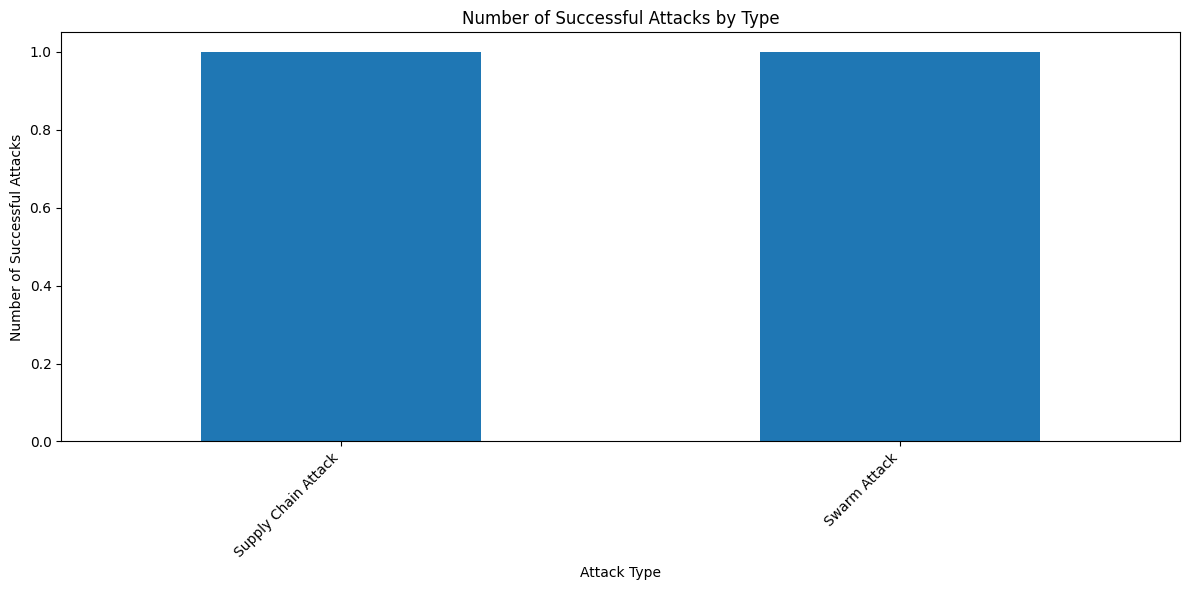

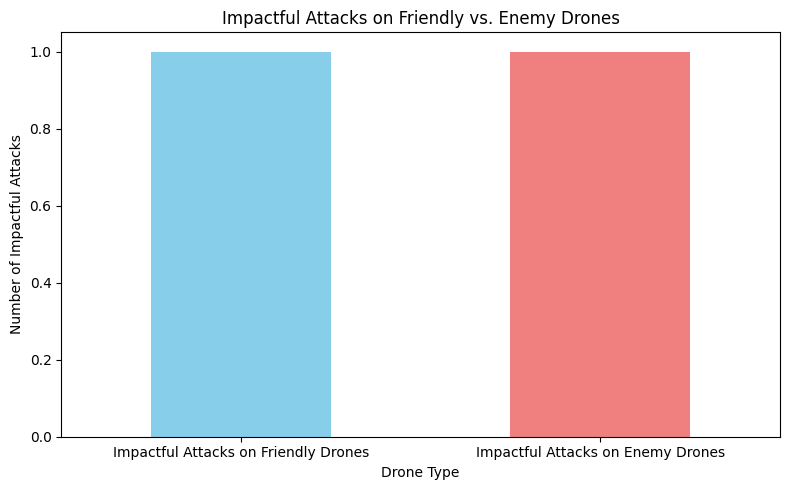

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'report' variable contains the output from the scenario execution

if 'report' in locals():
    successful_attacks = report.get('successful_attacks', [])
    war_metrics = report.get('war_scenario_metrics', {})

    # Prepare data for visualization
    attack_types = [attack.get('attack_type', 'Unknown') for attack in successful_attacks]
    attack_type_counts = pd.Series(attack_types).value_counts()

    # Create a bar chart of successful attacks by type
    plt.figure(figsize=(12, 6))
    attack_type_counts.plot(kind='bar')
    plt.title('Number of Successful Attacks by Type')
    plt.xlabel('Attack Type')
    plt.ylabel('Number of Successful Attacks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Create a bar chart of impactful attacks on friendly vs. enemy drones
    impactful_friendly = war_metrics.get('impactful_attacks_on_friendly', 0)
    impactful_enemy = war_metrics.get('impactful_attacks_on_enemy', 0)

    impact_counts = pd.Series({
        'Impactful Attacks on Friendly Drones': impactful_friendly,
        'Impactful Attacks on Enemy Drones': impactful_enemy
    })

    plt.figure(figsize=(8, 5))
    impact_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Impactful Attacks on Friendly vs. Enemy Drones')
    plt.xlabel('Drone Type')
    plt.ylabel('Number of Impactful Attacks')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


else:
    print("Report data not found. Please run the war scenario first.")

### Finish task
The visualizations provide a clear overview of the wargaming scenario results, showing the frequency of successful attack types and the distribution of impactful attacks between friendly and enemy drones.

The current simulation incorporates several key concepts and mechanisms relevant to drone cybersecurity, such as:

Various attack vectors: GPS spoofing, command injection, jamming, firmware exploits, swarm attacks, electronic warfare, and supply chain attacks are all real concerns in drone security.
Blue Team defenses: Firewalls, IDS, firmware patching, countermeasures, strong authentication, encryption, and supply chain monitoring represent actual defense strategies.
Probabilistic outcomes: The success and detection rates of attacks add a layer of realism by acknowledging that outcomes are not always certain.
Scenario-based simulation: Running different scenarios (like a war scenario) helps to model how these concepts interact in different contexts.
However, it's important to understand that this is a simplified model and not a perfect one-to-one representation of real-world drone cybersecurity for several reasons:

Simplified technical details: The simulation abstracts away many complex technical details of network protocols (like the full MAVLink standard), specific vulnerabilities, and the nuances of how attacks and defenses interact at a low level.
Abstracted drone behavior: The drone behavior is quite basic (simple movement, armed/disarmed states). Real drones have much more complex flight control systems, sensor data, and operational states.
Static defense effectiveness: The effectiveness of Blue Team actions is represented by fixed probabilities. In reality, defense effectiveness can vary greatly depending on the specific implementation, configuration, and the attacker's sophistication.
Limited environmental factors: Real-world scenarios involve complex environmental factors (weather, terrain, electromagnetic interference) that can significantly impact communication, GPS, and attack/defense effectiveness, which are not fully modeled here.
No human element: The simulation doesn't account for human operators, decision-making under pressure, or the human factors involved in both attacking and defending drones.
In summary: The simulation provides a valuable framework for exploring cybersecurity concepts and their potential interactions in a drone context. It's useful for understanding general principles and comparing the relative effectiveness of different strategies. However, for in-depth analysis or predicting outcomes in a specific real-world scenario, a more detailed and complex simulation or actual testing would be required.